### Introduction

Since this invloves analysing bags of words we will be using a Bag class to make the code easier to understand and reduce repetition of code. After that we define the similarity functions that will be used to analyse efficiency.

In [2]:
from collections import Counter
from nltk.tokenize import word_tokenize
import numpy as np
import math
import nltk
from functools import reduce
import operator

nltk.download('punkt')

#Class that implements a bag type data structure
class Bag:    
    #Constructor
    def __init__(self, contents=[]):
        self.__bag = list(contents)

    #Returns the size of the bag
    def __len__(self):
        return len(self.__bag)

    #Returns the value at the given index
    def __getitem__(self, index):
        return self.__bag[index]

    #Returns the number of times the given value appears in the bag
    def count(self, value):
        return self.__bag.count(value)

    #Returns dictionary of values in bag and counts for each value
    def counts(self):
        counts = dict()
        for word in self.__bag:
            if word in counts:
                counts[word] += 1
            else:
                counts[word] = 1
        return counts

    #Adds the given value to the bag
    def add(self, value):
        self.__bag.append(value)

    #Removes the given value from the bag
    def remove(self, value):
        self.__bag.remove(value)
    #Returns the values in the bag
    def __str__(self):
        return str(self.__bag)

    #Returns the values in the bag
    def values(self):
        return self.__bag

    #Returns the number of values in the bag
    def size(self):
        return len(self.__bag)

    #Returns the number of values in the bag
    def __repr__(self):
        return str(self.__bag)
    
    #Returns an iterator for the bag
    def __iter__(self):
        return iter(self.__bag)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jingl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Utility Functions

In [3]:
import time
import random
import matplotlib.pyplot as plt

#Function to find the time taken to run an input function
def timeit(somefunc,*args,repeats=100,**kwargs):
    times=[]
    for i in range(repeats):
        starttime=time.time()
        ans=somefunc(*args,**kwargs)
        endtime=time.time()
        timetaken=endtime-starttime
        times.append(timetaken)
    
    mean=np.mean(times)
    stdev=np.std(times)
    error=stdev/(repeats**0.5)
 
    return (ans,mean,error)

#Function that takes a list of words and choose n words from that list
#If unique is true then each word chosen will be unique, n < len(word_list)
#If unique is false then there is no guarantee that a chosen word will be unique
def choose_n_words(word_list, n, unique):
    if unique:
        return random.sample(word_list, n)
    else:
        return random.choices(word_list, k=n)

#Create list of numbers in a chosen base with the min and max specified by
#base**min and base**max. The number of sub_divisions specifies how many 'samples'
#to take between each value of i for base**i.
#This is useful to look at large ranges without needing huge numbers of samples
def power_list(base, min_exponent, max_exponent, sub_divisions):
    powers_sub_divisions = []

    for i in range(min_exponent ,max_exponent):

        elem1 = base**i
        elem2 = base**(i+1)
        stepsize = elem2 // sub_divisions

        for n in range(sub_divisions):
            powers_sub_divisions.append(elem1 + n*stepsize)

    powers_sub_divisions.append(elem2)
    out = list(set(powers_sub_divisions))
    out.sort()

    return [x for x in out if x <= base**max_exponent]

#Function that takes a word_list, a similarity function, and a range of document lengths to 
#perform the similarity function over
def number_of_words_vs_time(word_list, number_of_words_range, unique_words, similarity_func, *args, repeats=1):
    times = []
    number_of_words = []

    for j in number_of_words_range:
        bag_1 = Bag(choose_n_words(word_list, j, unique_words))
        bag_2 = Bag(choose_n_words(word_list, j, unique_words))

        results = timeit(similarity_func, bag_1, bag_2, *args, repeats=repeats)

        number_of_words.append(j)
        times.append(results[1])
    
    return number_of_words, times

#Plot number_of_words_vs_time
def plot_number_of_words_vs_time(   word_list,\
                                    number_of_words_range,\
                                    unique_words,\
                                    similarity_function,\
                                    *args,\
                                    repeats=1,\
                                    plot_label="Number of Words",\
                                    best_fit_plot_label="Line of Best Fit"):

    number_of_words, times = number_of_words_vs_time(   word_list,\
                                                        number_of_words_range,\
                                                        unique_words,\
                                                        similarity_function,\
                                                        *args,\
                                                        repeats=repeats)

    constants = stats.linregress(np.log(number_of_words), np.log(times))
    print(best_fit_plot_label + " constants: ", constants)

    line_of_best_fit = [np.exp(constants[1])*x**constants[0] for x in number_of_words_range]

    plt.plot(number_of_words, line_of_best_fit, label=best_fit_plot_label)
    plt.plot(number_of_words, times, label=plot_label)

    plt.ylabel("Time of Operation")
    plt.xlabel("Number of Words")
    plt.legend()

[10, 60, 100, 600, 1000, 6000, 10000, 60000, 100000]


In [45]:
import random
import string

#Instead of using a document of actual words it is easier to create random
#combinations of letters. This doesn't matter for similarity measures as they 
#don't need to be actual words.
#The advantage here is the ability to create documents with varying lengths easily
def create_word_list(number_of_words):
    s = string.ascii_lowercase
    word_list = []
    word_length = math.ceil(np.log(number_of_words)/np.log(26)) + 2

    for i in range(number_of_words):
        word_list.append(''.join(random.choice(s) for i in range(word_length)))
    
    return word_list

list_of_words_1M = create_word_list(10**6)

<center> <h1>Section I - Jaccard's Similarity</h1> </center>

In this section we will derive the time complexity of Jaccard's similarity measure applied to large documents represented as bags of words. We will then test the theoretical analysis against emperical results from running an implementation of Jaccard's similarity measure on documents of various sizes.

In [6]:
#Function that computes Jaccard similarity of two bags
def jaccard_similarity(bag1: Bag, bag2: Bag):
    counts1 = bag1.counts()
    counts2 = bag2.counts()

    #Swap order of counts to ensure minimum number of comparisons 
    #are computed to get the intersection
    if bag1.size() > bag2.size():
        counts1, counts2 = counts2, counts1

    #Compute the intersection for the two bags
    intersection = 0
    for element in counts1:
        if element in counts2:
        # if counts2[element] > 0:
            intersection += min(counts1[element], counts2[element])
    
    #Compute the union for the two bags
    union = bag1.size() + bag2.size() - intersection

    #Return the jaccard similarity
    return intersection / union

### Time Complexity

For the implementation for jaccard similarity above, the steps are:

* Create a dictionary of counts for word occurences in the first bag $\mathcal{O}(n_1)$
    - Create dictionary $\mathcal{O}(1)$
    - For each word in the bag increment the value of dictionary[word] by one $\mathcal{O}(n_1)$

* Create a dictionary of counts for word occurences in the second bag $\mathcal{O}(n_2)$

* Check dictionary sizes and swap if needed to ensure minimum number of operations are performed to compute the intersection $\mathcal{O}(2)$

* For each element in the first dictionary: $\mathcal{O}(min(n_{unique_1}, n_{unique_2}))$
    - Check if element is in the second dictionary $\mathcal{O}(1)$
    - If it is add the minimum value of the first and second dictonary to the intersection $\mathcal{O}(1)$

* Compute the union $\mathcal{O}(1)$

* Divide the intersection by the union $\mathcal{O}(1)$

Therefore, the theoretical running time of this algorithm is 
$$
\begin{equation*}
\begin{align*}
\mathcal{O}_{total}   &= \mathcal{O}(n_1) + \mathcal{O}(n_2) + \mathcal{O}(2) + \mathcal{O}(min(n_{unique_1}, n_{unique_2})) + \mathcal{O}(1) + \mathcal{O}(1)\\
            &\approx\mathcal{O}(n_1) + \mathcal{O}(n_2) + \mathcal{O}(min(n_{unique_1}, n_{unique_2})).
\end{align*}
\end{equation*}
$$ 

Here $n_1$ and $n_2$ are the original starting bag sizes, and $n_{unique_1}$ and $n_{unique_2}$ are the the number of unique elements in each starting bag. In the worst-case

$$
\begin{equation*}
\begin{align*}
n_{unique_1} &= n_1\\
n_{unique_2} &= n_2\\
min(n_{unique_1}, n_{unique_2}) &= min(n_1, n_2).
\end{align*}
\end{equation*}
$$ 

Therefore, the theoretical running time of this algorithm in the worst-case is 

$$
\begin{equation*}
\begin{align*}
\mathcal{O}_{total} &=\mathcal{O}(n_1) + \mathcal{O}(n_2) + \mathcal{O}(min(n_1, n_2))\\
                    &\approx\mathcal{O}(max(n_1, n_2)).
\end{align*}
\end{equation*}
$$ 

### Jaccard Similarity Unique vs Non-Unique Words

[10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000, 46000, 47000, 48000, 49000, 50000, 51000, 52000, 53000, 54000, 55000, 56000, 57000, 58000, 59000, 60000, 61000, 62000, 63000, 64000, 65000, 66000, 67000, 68000, 69000, 70000, 71000, 72000, 73000, 74000, 75000, 76000, 77000, 78000, 79000, 80000, 81000, 82000, 83000, 84000, 85000, 86000, 87000, 88000, 89000, 90000, 91000, 92000, 93000, 94000, 95000, 96000, 97000, 98000, 99000, 100000]
Line of Best Fit Unique constants:  LinregressResult(slope=1.0689177436874016, intercept=-14.702698008192547, rvalue=0.9911938327073956, pvalue=6.072287766697052e-80, stderr=0.015137038893758918, intercept_stderr=0.16319003619178274)
Line of Best Fit Non-Unique constants:  LinregressResult(slope=0.8493668762993493, intercept=-13.73718480077835, rvalue=0.95854

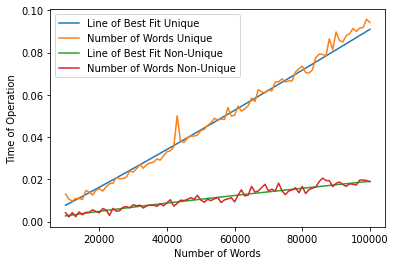

In [51]:
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats

words = list_of_words_1M

#Plot jaccard similarty for documents that only contain unique words
number_of_words_range = power_list(10, 4, 5, 100)
unique_words = True
similarity_function = jaccard_similarity
best_fit_plot_label = "Line of Best Fit Unique"
plot_label = "Number of Words Unique"
plot_number_of_words_vs_time(   words,\
                                number_of_words_range,\
                                unique_words,\
                                similarity_function,\
                                repeats=4,\
                                best_fit_plot_label=best_fit_plot_label,\
                                plot_label=plot_label)

#Plot jaccard similarty for documents that only contain on unique word
words = choose_n_words(list_of_words_1M, 1, True)
unique_words = False
best_fit_plot_label = "Line of Best Fit Non-Unique"
plot_label = "Number of Words Non-Unique"
plot_number_of_words_vs_time(   words,\
                                number_of_words_range,\
                                unique_words,\
                                similarity_function,\
                                repeats=4,\
                                best_fit_plot_label=best_fit_plot_label,\
                                plot_label=plot_label)

plt.show()

From the above plot and lines of best fit we can see that for large documents Jaccard's similarity measure increases linearly with respect to the number of words in documents. This is true for both documents where there are no repeated words and also for documents which only contain one unique word. However, it is clear from the plots that for documents with only unique words that the Jaccard similarity increase at a faster rate. This is due to having to having to perform more comparisons to check if each word in one document is also in the other. In documents with only one unique word there is also only one comparison to be made hence the smaller graident.

The lines of best fit are:
* Unique words $\approx ax^1$
* Non-Unique words $\approx ax^1$ 

<center> <h1>Section II - Dense Cosine Similarity</h1> </center>


In this section we will derive the time complexity of the dense cosine similarity measure applied to large documents represented as bags of words. We will then test the theoretical analysis against emperical results from running an implementation of the dense cosine similarity measure on documents of various sizes. Finally we will compare the performance of the dense cosine similarity using python lists for the dot-product vs using numpy.

In [7]:
#Function that computes Cosine similarity of two bags using dense vector representations
def dense_cosine_similarity(bag1: Bag, bag2: Bag, using_numpy_dot=False):
    import math
    counts1 = bag1.counts()
    counts2 = bag2.counts()
    
    #Create list containing all words in bag1 and bag2
    all_words = list(set(counts1.keys()).union(set(counts2.keys())))
    
    #Create vectors for bag1 and bag2
    vector1 = [counts1[word] if word in counts1 else 0 for word in all_words]
    vector2 = [counts2[word] if word in counts2 else 0 for word in all_words]

    #Compute cosine similarity
    if not using_numpy_dot:
        dot_product = sum([x*y for x,y in zip(vector1, vector2)])
        magnitude1 = math.sqrt(sum([x**2 for x in vector1]))
        magnitude2 = math.sqrt(sum([x**2 for x in vector2]))
    else:
        dot_product = np.dot(vector1, vector2)
        magnitude1 = np.linalg.norm(vector1)
        magnitude2 = np.linalg.norm(vector1)
        
    return dot_product/(magnitude1*magnitude2)

### Time Complexity

For the implementation for the dense cosine similarity above, the steps are:

* Create a dictionary of counts for word occurences in the first bag $\mathcal{O}(n_1)$
    - Create dictionary $\mathcal{O}(1)$
    - For each word in the bag increment the value of dictionary[word] by one $\mathcal{O}(n_1)$

* Create a dictionary of counts for word occurences in the second bag $\mathcal{O}(n_2)$

* Create a list of all of the unique words in in both bags $2\mathcal{O}(n_{unique_1}) + 2\mathcal{O}(n_{unique_2})$
    - Create set from keys of first dictionary of counts $\mathcal{O}(n_{unique_1})$
    - Create set from keys of second dictionary of counts $\mathcal{O}(n_{unique_2})$
    - Take the union of both sets, worst-case $\mathcal{O}(n_{unique_1}) + \mathcal{O}(n_{unique_2})$

* Create vector representing first dictionary of counts using list of all words, worst-case $\mathcal{O}(n_{unique_1} + n_{unique_2})$

* Create vector representing second dictionary of counts using list of all words, worst-case $\mathcal{O}(n_{unique_1} + n_{unique_2})$

* Calculate the dot product between the two vectors, worst-case $2\mathcal{O}(n_{unique_1} + n_{unique_2})$

* Calculate the magnitude of the vector representing the first dictionary of counts $\mathcal{O}(n_{unique_1} + n_{unique_2})$

* Calculate the magnitude of the vector representing the second dictionary of counts $\mathcal{O}(n_{unique_1} + n_{unique_2})$

* Divide the dot product with the product of the magnitudes $\mathcal{O}(1)$


Therefore, the theoretical running time of this algorithm is 
$$
\begin{equation*}
\begin{align*}
\mathcal{O}_{total}   &= \mathcal{O}(n_1) + \mathcal{O}(n_2)+ 2\mathcal{O}(n_{unique_1}) + 2\mathcal{O}(n_{unique_2}) + \mathcal{O}(n_{unique_1} + n_{unique_2}) + \mathcal{O}(n_{unique_1} + n_{unique_2})\\
&+ 2\mathcal{O}(n_{unique_1} + n_{unique_2}) + \mathcal{O}(n_{unique_1} + n_{unique_2}) + \mathcal{O}(n_{unique_1} + n_{unique_2}) + \mathcal{O}(1)
\end{align*}
\end{equation*}
$$ 

Here $n_1$ and $n_2$ are the original starting bag sizes, and $n_{unique_1}$ and $n_{unique_2}$ are the the number of unique elements in each starting bag. In the worst-case

$$
\begin{equation*}
\begin{align*}
n_{unique_1} &= n_1\\
n_{unique_2} &= n_2
\end{align*}
\end{equation*}
$$

in which case the theoretical running time of this algorithm is 
$$
\begin{equation*}
\begin{align*}
\mathcal{O}_{total}     &= \mathcal{O}(n_1) + \mathcal{O}(n_2) + 2\mathcal{O}(n_1) + 2\mathcal{O}(n_2) + \mathcal{O}(n_1 + n_2) + \mathcal{O}(n_1 + n_2)\\
&+ 2\mathcal{O}(n_1 + n_2) + \mathcal{O}(n_1 + n_2) + \mathcal{O}(n_1 + n_2) + \mathcal{O}(1)\\
                        &= 8\mathcal{O}(n_1) + 8\mathcal{O}(n_2) + \mathcal{O}(1)\\
                        &\approx\mathcal{O}(max(n_1, n_2))
\end{align*}
\end{equation*}
$$ 

### Dense Cosine Unique vs Non-Unique Words

[10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000, 46000, 47000, 48000, 49000, 50000, 51000, 52000, 53000, 54000, 55000, 56000, 57000, 58000, 59000, 60000, 61000, 62000, 63000, 64000, 65000, 66000, 67000, 68000, 69000, 70000, 71000, 72000, 73000, 74000, 75000, 76000, 77000, 78000, 79000, 80000, 81000, 82000, 83000, 84000, 85000, 86000, 87000, 88000, 89000, 90000, 91000, 92000, 93000, 94000, 95000, 96000, 97000, 98000, 99000, 100000]
Line of Best Fit Unique constants:  LinregressResult(slope=0.9604421534741866, intercept=-11.89676045770375, rvalue=0.9512959386227651, pvalue=2.9056273042030785e-47, stderr=0.032991702411548446, intercept_stderr=0.35567835614064086)
Line of Best Fit Non-Unique constants:  LinregressResult(slope=0.9515544822691726, intercept=-14.325325945473903, rvalue=0.9580

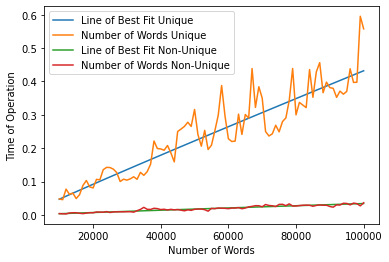

In [52]:
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats

words = list_of_words_1M

#Plot cosine similarty for documents that only contain unique words
number_of_words_range = power_list(10, 4, 5, 100)
unique_words = True
similarity_function = dense_cosine_similarity
with_numpy = False
best_fit_plot_label = "Line of Best Fit Unique"
plot_label = "Number of Words Unique"

plot_number_of_words_vs_time(   words,\
                                number_of_words_range,\
                                unique_words,\
                                similarity_function,\
                                with_numpy,\
                                repeats=4,\
                                best_fit_plot_label=best_fit_plot_label,\
                                plot_label=plot_label)

#Plot jaccard similarty for documents that only contain one unique word
words = choose_n_words(list_of_words_1M, 1, True)
unique_words = False
best_fit_plot_label = "Line of Best Fit Non-Unique"
plot_label = "Number of Words Non-Unique"

plot_number_of_words_vs_time(   words,\
                                number_of_words_range,\
                                unique_words,\
                                similarity_function,\
                                with_numpy,\
                                repeats=4,\
                                best_fit_plot_label=best_fit_plot_label,\
                                plot_label=plot_label)

plt.show()

From the above plot and lines of best fit we can see that for large documents the dense cosine similarity measure increases linearly with respect to the number of words in documents. This is true for both documents where there are no repeated words and also for documents which only contain one unique word. However, it is clear from the plots that for documents with only unique words that the dense cosine similarity increase at a faster rate. This is due to having to create two vectors both of which have a length that equals the number of elements in the union of unique elements from each document. when comparing documents with only one unique word each there will be at most two elements in the union and therefore we will only be performing the dot product between the two elements. This will not increase not matter how many words in the original documents. However, for documents with only unique words this dot product maybe be between two vectors of length, in the worst-case scenario, equal to the number of elements in both documents combined.

The lines of best fit are:
* Unique words $\approx ax^1$
* Non-Unique words $\approx ax^1$ 

### Dense Cosine Numpy vs No Numpy Dot Product 

[10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000, 46000, 47000, 48000, 49000, 50000, 51000, 52000, 53000, 54000, 55000, 56000, 57000, 58000, 59000, 60000, 61000, 62000, 63000, 64000, 65000, 66000, 67000, 68000, 69000, 70000, 71000, 72000, 73000, 74000, 75000, 76000, 77000, 78000, 79000, 80000, 81000, 82000, 83000, 84000, 85000, 86000, 87000, 88000, 89000, 90000, 91000, 92000, 93000, 94000, 95000, 96000, 97000, 98000, 99000, 100000]
Line of Best Fit Without Numpy constants:  LinregressResult(slope=1.077721090366143, intercept=-13.305988461024311, rvalue=0.9899500323105631, pvalue=2.1140671843214976e-77, stderr=0.016319299872758635, intercept_stderr=0.1759358059097058)
Line of Best Fit With Numpy constants:  LinregressResult(slope=1.036580473210146, intercept=-12.94521081124008, rvalue=0.

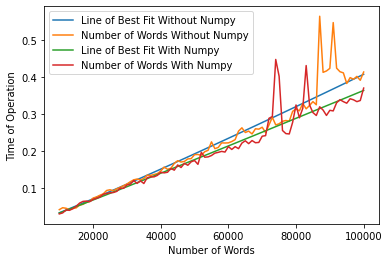

In [53]:
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats

words = list_of_words_1M

#Plot dense cosine similarity without numpy
number_of_words_range = power_list(10, 4, 5, 100)
unique_words = True
similarity_function = dense_cosine_similarity
with_numpy = False
best_fit_plot_label = "Line of Best Fit Without Numpy"
plot_label = "Number of Words Without Numpy"

plot_number_of_words_vs_time(   words,\
                                number_of_words_range,\
                                unique_words,\
                                similarity_function,\
                                with_numpy,\
                                repeats=4,\
                                best_fit_plot_label=best_fit_plot_label,\
                                plot_label=plot_label)

#Plot dense cosine similarity with numpy
unique_words = False
with_numpy = True
best_fit_plot_label = "Line of Best Fit With Numpy"
plot_label = "Number of Words With Numpy"

plot_number_of_words_vs_time(   words,\
                                number_of_words_range,\
                                unique_words,\
                                similarity_function,\
                                with_numpy,\
                                repeats=4,\
                                best_fit_plot_label=best_fit_plot_label,\
                                plot_label=plot_label)

plt.show()

From the above plot it is apparent that performing the dot-product using numpy increase the speed of the algorithm. This is expected as numpy has more effient methods for computing the dot-product than using python lists. However, the time complexity of the algorithm still increases linearly as the performing the dot-product is not the limiting factor. As previously discussed the limiting factor will be creating the dictionary of counts for each document and this has a linear time complexity.

The lines of best fit are:
* Unique words $\approx ax^1$
* Non-Unique words $\approx ax^1$ 

<center> <h1>Section III - Sparse Cosine Similarity</h1> </center>


In this section we will derive the time complexity of the sparse cosine similarity measure applied to large documents represented as bags of words. We will then test the theoretical analysis against emperical results from running an implementation of the sparse cosine similarity measure on documents of various sizes. Finally we will compare the performance of the sparse cosine similarity against the dense cosine similarity and Jaccard's similarity.

In [8]:
#Function that computes Cosine similarity of two bags using sparse vector representations
def sparse_cosine_similarity(bag1: Bag, bag2: Bag):
    counts1 = bag1.counts()
    counts2 = bag2.counts()

    #Swap order of counts to ensure minimum number of comparisons 
    #are computed to get the intersection
    if bag1.size() < bag2.size():
        counts1, counts2 = counts2, counts1
        
    #Compute the 'dot product' for the sparse representation
    intersection = 0
    for element in counts1:
        if element in counts2:
        # if counts2[element] > 0:
            intersection += counts1[element] * counts2[element]

    #Compute the norm for the first bag
    norm1 = 0
    for element in counts1:
        norm1 += counts1[element] ** 2
    norm1 = math.sqrt(norm1)

    #Compute the norm for the second bag
    norm2 = 0
    for element in counts2:
        norm2 += counts2[element] ** 2
    norm2 = math.sqrt(norm2)

    #Return the cosine similarity
    return intersection / (norm1 * norm2)

### Time Complexity

For the implementation for the dense cosine similarity above, the steps are:

* Create a dictionary of counts for word occurences in the first bag $\mathcal{O}(n_1)$
    - Create dictionary $\mathcal{O}(1)$
    - For each word in the bag increment the value of dictionary[word] by one $\mathcal{O}(n_1)$

* Create a dictionary of counts for word occurences in the second bag $\mathcal{O}(n_2)$

* Check dictionary sizes and swap if needed to ensure minimum number of operations are performed to compute the intersection $\mathcal{O}(2)$

* For each element in the first dictionary: $\mathcal{O}(min(n_{unique_1}, n_{unique_2}))$
    - Check if element is in the second dictionary $\mathcal{O}(1)$
    - If it is multiply the values from the first and second dictonaries $\mathcal{O}(1)$

* Calculate the magnitude of the vector representing the first dictionary of counts $\mathcal{O}(n_{unique_1})$

* Calculate the magnitude of the vector representing the second dictionary of counts $\mathcal{O}(n_{unique_2})$

* Divide the dot product with the product of the magnitudes $\mathcal{O}(1)$


Therefore, the theoretical running time of this algorithm is 
$$
\begin{equation*}
\begin{align*}
\mathcal{O}_{total}   &= \mathcal{O}(n_1) + \mathcal{O}(n_2)+ \mathcal{O}(2) + \mathcal{O}(min(n_{unique_1}, n_{unique_2})) + \mathcal{O}(n_{unique_1}) + \mathcal{O}(n_{unique_2}) + \mathcal{O}(1)
\end{align*}
\end{equation*}
$$ 

Here $n_1$ and $n_2$ are the original starting bag sizes, and $n_{unique_1}$ and $n_{unique_2}$ are the the number of unique elements in each starting bag. In the worst-case

$$
\begin{equation*}
\begin{align*}
n_{unique_1} &= n_1\\
n_{unique_2} &= n_2
\end{align*}
\end{equation*}
$$

in which case the theoretical running time of this algorithm is 
$$
\begin{equation*}
\begin{align*}
\mathcal{O}_{total}     &= \mathcal{O}(n_1) + \mathcal{O}(n_2) + \mathcal{O}(2) + \mathcal{O}(min(n_1, n_2)) + \mathcal{O}(n_1) + \mathcal{O}(n_2) + \mathcal{O}(1)\\
                        &\approx \mathcal{O}(max(n_1, n_2))
\end{align*}
\end{equation*}
$$ 

### Sparse Cosine Similarity Unique vs Non-Unique Words

[10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000, 46000, 47000, 48000, 49000, 50000, 51000, 52000, 53000, 54000, 55000, 56000, 57000, 58000, 59000, 60000, 61000, 62000, 63000, 64000, 65000, 66000, 67000, 68000, 69000, 70000, 71000, 72000, 73000, 74000, 75000, 76000, 77000, 78000, 79000, 80000, 81000, 82000, 83000, 84000, 85000, 86000, 87000, 88000, 89000, 90000, 91000, 92000, 93000, 94000, 95000, 96000, 97000, 98000, 99000, 100000]
Line of Best Fit Unique Words constants:  LinregressResult(slope=1.192674753576186, intercept=-15.095919039433475, rvalue=0.9421550764305199, pvalue=5.020398823984785e-44, stderr=0.044975832244315214, intercept_stderr=0.48487737550383836)
Line of Best Fit Non-Unique Words constants:  LinregressResult(slope=1.142014057314582, intercept=-16.877227148635328, rva

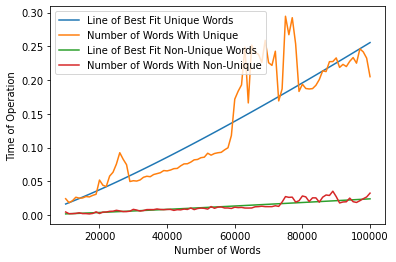

In [55]:
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats

words = list_of_words_1M

#Plot cosine similarty for documents that only contain unique words
number_of_words_range = power_list(10, 4, 5, 100)
unique_words = True
similarity_function = sparse_cosine_similarity
best_fit_plot_label = "Line of Best Fit Unique Words"
plot_label = "Number of Words With Unique"

plot_number_of_words_vs_time(   words,\
                                number_of_words_range,\
                                unique_words,\
                                similarity_function,\
                                repeats=4,\
                                best_fit_plot_label=best_fit_plot_label,\
                                plot_label=plot_label)

#Plot cosine similarty for documents that only contain one unique word            
words = choose_n_words(list_of_words_1M, 1, True)
unique_words = False
best_fit_plot_label = "Line of Best Fit Non-Unique Words"
plot_label = "Number of Words With Non-Unique"

plot_number_of_words_vs_time(   words,\
                                number_of_words_range,\
                                unique_words,\
                                similarity_function,\
                                repeats=4,\
                                best_fit_plot_label=best_fit_plot_label,\
                                plot_label=plot_label)

plt.show()

From the above plot and lines of best fit we can see that for large documents the sparse cosine similarity measure increases linearly with respect to the number of words in documents. This is true for both documents where there are no repeated words and also for documents which only contain one unique word. However, it is clear from the plots that for documents with only unique words that the sparse cosine similarity increase at a faster rate. This is due to having to having to check if each word in one document is also in the other and then multiply the values if it is. In documents with only one unique word there is also only one comparison to be made hence the smaller graident.

The lines of best fit are:
* Unique words $\approx ax^1$
* Non-Unique words $\approx ax^1$ 

### Sparse Cosine Similarity vs Dense Cosine Similarity vs Jaccard Similarity

[10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000, 46000, 47000, 48000, 49000, 50000, 51000, 52000, 53000, 54000, 55000, 56000, 57000, 58000, 59000, 60000, 61000, 62000, 63000, 64000, 65000, 66000, 67000, 68000, 69000, 70000, 71000, 72000, 73000, 74000, 75000, 76000, 77000, 78000, 79000, 80000, 81000, 82000, 83000, 84000, 85000, 86000, 87000, 88000, 89000, 90000, 91000, 92000, 93000, 94000, 95000, 96000, 97000, 98000, 99000, 100000]
Line of best fit constants:  LinregressResult(slope=0.9440538897872393, intercept=-11.87699901751263, rvalue=0.9583054676105365, pvalue=3.3596774254260347e-50, stderr=0.029838541330602052, intercept_stderr=0.3216846223245561)
Line of best fit constants:  LinregressResult(slope=1.1492268369192546, intercept=-14.870007822819655, rvalue=0.9934905300140386, pvalu

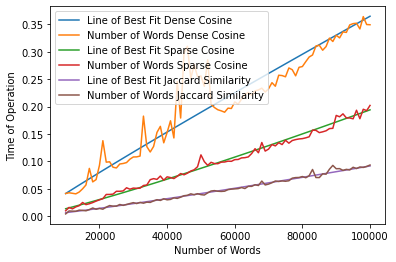

In [38]:
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats

words = list_of_words_1M

#Plot dense cosine similarty
number_of_words_range = power_list(10, 4, 5, 100)
unique_words = True
similarity_function = dense_cosine_similarity
with_numpy = False
best_fit_plot_label = "Line of Best Fit Dense Cosine"
plot_label = "Number of Words Dense Cosine"

plot_number_of_words_vs_time(   words,\
                                number_of_words_range,\
                                unique_words,\
                                similarity_function,\
                                with_numpy,\
                                repeats=4,\
                                best_fit_plot_label=best_fit_plot_label,\
                                plot_label=plot_label)

#Plot sparse cosine similarity
similarity_function = sparse_cosine_similarity
unique_words = True
best_fit_plot_label = "Line of Best Fit Sparse Cosine"
plot_label = "Number of Words Sparse Cosine"

plot_number_of_words_vs_time(   words,\
                                number_of_words_range,\
                                unique_words,\
                                similarity_function,
                                repeats=4,\
                                best_fit_plot_label=best_fit_plot_label,\
                                plot_label=plot_label)

#Plot jaccard similarity
similarity_function = jaccard_similarity
unique_words = True
best_fit_plot_label = "Line of Best Fit Jaccard Similarity"
plot_label = "Number of Words Jaccard Similarity"

plot_number_of_words_vs_time(   words,\
                                number_of_words_range,\
                                unique_words,\
                                similarity_function,
                                repeats=4,\
                                best_fit_plot_label=best_fit_plot_label,\
                                plot_label=plot_label)

plt.show()

From the above plot we can see that Jaccard's similarity is most efficient, followed by sparse cosine, and finally dense cosine is the least efficient. Since we have already discussed the differences between dense and sparse cosine efficiency above we shall instead look at why Jaccard's similarity is more efficient than sparse cosine. They are very similar algorithms to implement with the difference being that Jaccard takes the minimum of two values to produce the intersection and sparse cosine takes the product. However, this shouldn't produce a large visible difference in efficiency since taking the minimum and taking the product can be considered $\mathcal{O}(1)$. Instead, the difference arises from sparse cosine computing the magnitude for both dictionaries of counts. This is $\mathcal{O}(n)$ in the worst-case for both dictionaries and therefore sparse cosine is less efficient.

The lines of best fit are:
* Unique words $\approx ax^1$
* Non-Unique words $\approx ax^1$ 

<center> <h1>Section IV - Computing Similarities For Multiple Documents</h1> </center>


In this section we will computes all-pairs similarities for a collection of documents. We will derive the theoretical time complexity and give the worst-case scenario. This will include investigating both the cases where there are a large number of documents to compare and where each document has a large number of words. We will also investigate if it matters which similarity measure is used.

In [36]:
import itertools

#Function which computes all-pairs similarities for a collection of documents
def compute_similarities(documents: list, similarity_function: str):
    bags=[]
    for doc in documents:
        bag = Bag(word_tokenize(doc))
        bags.append(bag)
    
    #Assign correct similarity function depending on input
    if similarity_function == "jaccard_similarity":
        func = jaccard_similarity
    elif similarity_function == "dense_cosine_similarity":
        func = dense_cosine_similarity
    elif similarity_function == "sparse_cosine_similarity":
        func = sparse_cosine_similarity
    else:
        raise ValueError("Invalid similarity function")
    
    #Compute similarity comparison for every pair of documents    
    combinations = itertools.combinations(range(len(bags)), 2)
    indices_1 = [x[0] for x in combinations]
    indices_2 = [x[1] for x in combinations]
    bags_1 = [bags[x]  for x in indices_1]
    bags_2 = [bags[x]  for x in indices_2]

    similarities = []
    for i,j, bag_1, bag_2 in zip(indices_1, indices_2, bags_1, bags_2):
        similarities.append((i, j, func(bag_1, bag_2)))
    
    return similarities

### Time Complexity

For the implementation for the compute_similarity function above, the steps are:

* Turn list of documents into a list of bags of words $\mathcal{O}(n_1) + \mathcal{O}(n_2) + \ldots + \mathcal{O}(n_d)$, $n_d$ indicates the length of the $d^{th}$ document
    * Create list $\mathcal{O}(1)$
    * For each document:
        * Create bag $\mathcal{O}(1)$
        * Tokenise document $\mathcal{O}(n)$
        * Add each word to bag $\mathcal{O}(1)$
    * Add bag to list $\mathcal{O}(1)$

* Assign correct similarity function $\mathcal{O}(1)$

* Create all possible combinations of 2-pair indices without repeats $\mathcal{O}(\frac{d(d-1)}{2})$

* Create list of bags corresponding to the first index in the list of 2-pair indices $\mathcal{O}(\frac{d(d-1)}{2})$

* Create list of bags corresponding to the second index in the list of 2-pair indices $\mathcal{O}(\frac{d(d-1)}{2})$

* For each bag in the zip of the first and second list of bags compute the similarities. Taking all $n_{unique_i} = n_{unique_j} = n_{unique} \forall i,j$ this give the worst-case as $\mathcal{O}\left(\frac{d(d-1)}{2}n_{unique}\right)$:
    * Compute similarity between $bag_{i}$ and $bag_{j}$ $\mathcal{O}(max(n_{unique_i}, n_{unique_j})$

Therefore, the theoretical running time of this algorithm is 
$$
\begin{equation*}
\begin{align*}
\mathcal{O}_{total}     &= \mathcal{O}(n_1) + \mathcal{O}(n_2) + \ldots + \mathcal{O}(n_d) + \mathcal{O}(\frac{d(d-1)}{2}) + \mathcal{O}(\frac{d(d-1)}{2}) + \mathcal{O}(\frac{d(d-1)}{2})\\
                        &+ \mathcal{O}\left(\frac{d(d-1)}{2}n_{unique}\right)
\end{align*}
\end{equation*}
$$

where where have ignored $\mathcal{O}(1)$ for simplicity.

Here $n_1, n_2, \ldots,n_d $ are the original starting bag sizes, $n_{unique_1}, n_{unique_2}, \ldots, n_{unique_d}$ are the the number of unique elements in each starting bag, and $d$ is the number of documents. In the worst-case

$$
\begin{equation*}
\begin{align*}
n_{unique_1} &= n_1\\
n_{unique_2} &= n_2\\
&\vdots\\
n_{unique_d} &= n_d\\
n &= n_1 = n_2 = \ldots = n_d
\end{align*}
\end{equation*}
$$

in which case the theoretical running time of this algorithm is 
$$
\begin{equation*}
\begin{align*}
\mathcal{O}_{total}     &= \mathcal{O}(n) + \mathcal{O}(n) + \ldots + \mathcal{O}(n) + \mathcal{O}(\frac{d(d-1)}{2}) + \mathcal{O}(\frac{d(d-1)}{2}) + \mathcal{O}(\frac{d(d-1)}{2})\\
                        &+ \mathcal{O}\left(\frac{d(d-1)}{2}n\right)\\
                        &= d\mathcal{O}(n) + 3\mathcal{O}(\frac{d(d-1)}{2}) + \mathcal{O}\left(\frac{d(d-1)}{2}n\right)\\
                        &= \mathcal{O}(dn) + \mathcal{O}(\frac{3d(d-1)}{2}) + \mathcal{O}\left(\frac{d(d-1)}{2}n\right)\\
                        &\approx \mathcal{O}(dn) + \mathcal{O}(d^2) + \mathcal{O}\left(d^2n\right)\\
                        &\approx\mathcal{O}\left(d^2n\right)
\end{align*}
\end{equation*}
$$ 
        

### Utility Functions

In [46]:
#Function that takes a word_list, a similarity function, and a range of number of documents to 
#perform the similarity function over for a given constant document size
def number_of_docs_vs_time_constant_doc_length(word_list,\
                                                number_of_docs_range,\
                                                doc_length,\
                                                unique_words,\
                                                similarity_function,\
                                                repeats=1):
    times = []
    number_of_docs = []

    for i in number_of_docs_range:
        docs = []
        for j in range(i):
            docs.append(' '.join(choose_n_words(word_list, doc_length, unique_words)))
        results = timeit(compute_similarities, docs, similarity_function, repeats=repeats)

        times.append(results[1])
        number_of_docs.append(i)
    
    return number_of_docs, times

#Function that takes a word_list, a similarity function, and a range of document lengths to 
#perform the similarity function over for a given number of documents
def doc_length_vs_time_constant_number_of_docs( word_list,\
                                                doc_length_range,\
                                                number_of_docs,\
                                                unique_words,\
                                                similarity_function,\
                                                repeats=1):
    times = []
    doc_length = []

    for i in doc_length_range:
        docs = []
        for j in range(number_of_docs):
            docs.append(' '.join(choose_n_words(word_list, i, unique_words)))
        results = timeit(compute_similarities, docs, similarity_function, repeats=repeats)

        times.append(results[1])
        doc_length.append(i)
    
    return doc_length, times

#Plot how the time varies for computing similarity measure for a constant number of 
#documents with varying document lengths
def plot_doc_length_vs_time_constant_number_of_docs(    word_list,\
                                                        doc_length_range,\
                                                        number_of_docs,\
                                                        unique_words,\
                                                        similarity_function,
                                                        plot_label="Unique Words Constant Number of Documents",\
                                                        best_fit_plot_label="Line of Best Fit",\
                                                        repeats=1):

    doc_length, times = doc_length_vs_time_constant_number_of_docs( word_list,\
                                                                    doc_length_range,\
                                                                    number_of_docs,\
                                                                    unique_words,\
                                                                    similarity_function,\
                                                                    repeats)

    constants = stats.linregress(np.log(doc_length), np.log(times))
    print(best_fit_plot_label + " constants: ", constants)

    line_of_best_fit = [np.exp(constants[1])*x**constants[0] for x in doc_length_range]

    plt.plot(doc_length, line_of_best_fit, label=best_fit_plot_label)

    plt.plot(doc_length, times, label=plot_label)
    plt.ylabel("Time of Operation")
    plt.xlabel("Document Length")
    plt.legend()

#Plot how the time varies for computing similarity measure for a varying number of 
#documents with constant lengths
def plot_number_of_docs_vs_time_constant_doc_length( word_list,\
                                                number_of_docs_range,\
                                                doc_length,\
                                                unique_words,\
                                                similarity_function,\
                                                plot_label="Number of Documents Static Number of Words",\
                                                best_fit_plot_label="Line of Best Fit",\
                                                repeats=1):

    number_of_docs, times = number_of_docs_vs_time_constant_doc_length( word_list,\
                                                                        number_of_docs_range,\
                                                                        doc_length,\
                                                                        unique_words,\
                                                                        similarity_function,\
                                                                        repeats)

    constants = stats.linregress(np.log(number_of_docs), np.log(times))
    print(best_fit_plot_label + " constants: ", constants)

    line_of_best_fit = [np.exp(constants[1])*x**constants[0] for x in number_of_docs_range]

    plt.plot(number_of_docs, line_of_best_fit, label=best_fit_plot_label)

    plt.plot(number_of_docs, times, label=plot_label)
    plt.xlabel("Time of Operation")
    plt.ylabel("Number of Documents")
    plt.legend()


### Large Number of Unique Words vs Non-Unique Words for Constant Document Number

[1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000]
Line of Best Fit Unique constants:  LinregressResult(slope=0.7732623255811047, intercept=-9.572154011610584, rvalue=0.9643990367697328, pvalue=3.38984832537017e-53, stderr=0.022476092487662906, intercept_stderr=0.19065959513809688)
Line of Best Fit Non-Unique constants:  LinregressResult(slope=0.9471837826860335, intercept=-11.134421951916949, rvalue=0.9869901654582498, pvalue=1.9337000972840477e-72, stderr=0.01635536235527085, intercept_stderr=0.1

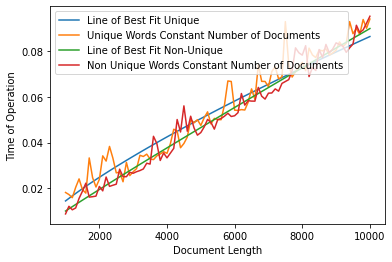

In [44]:
import scipy.stats as stats

words = list_of_words_1M

#Plot Jaccard similarity for a constant number of documents with varying document lengths with unique words
doc_length_range = power_list(10, 3, 4, 100)
number_of_docs = 2
unique_words = True
similarity_function = "jaccard_similarity"
plot_label = "Unique Words Constant Number of Documents"
best_fit_plot_label = "Line of Best Fit Unique"

plot_doc_length_vs_time_constant_number_of_docs(    words,\
                                                    doc_length_range,\
                                                    number_of_docs,\
                                                    unique_words,\
                                                    similarity_function,\
                                                    plot_label=plot_label,\
                                                    best_fit_plot_label=best_fit_plot_label,\
                                                    repeats=4)

#Plot Jaccard similarity for a constant number of documents with varying document lengths with non-unique words
words = choose_n_words(list_of_words_1M, 1, True)
unique_words = False
plot_label = "Non Unique Words Constant Number of Documents"
best_fit_plot_label = "Line of Best Fit Non-Unique"

plot_doc_length_vs_time_constant_number_of_docs(    words,\
                                                    doc_length_range,\
                                                    number_of_docs,\
                                                    unique_words,\
                                                    similarity_function,\
                                                    plot_label=plot_label,\
                                                    best_fit_plot_label=best_fit_plot_label,\
                                                    repeats=4)

plt.show()

This plot shows that for a constant number of documents being compared that as the document sizes grow it is not heavily affected by the number of unique words in the documents and that the runtime increase linearly.

The lines of best fit are:
* Unique words $\approx ax^1$
* Non-Unique words $\approx ax^1$ 

### Large Number of Documents Constant Unique Words

[1000, 1125, 1250, 1375, 1500, 1625, 1750, 1875, 2000, 2125, 2250, 2375, 2500, 2625, 2750, 2875, 3000, 3125, 3250, 3375, 3500, 3625, 3750, 3875, 4000, 4125, 4250, 4375, 4500, 4625, 4750, 4875, 5000, 5125, 5250, 5375, 5500, 5625, 5750, 5875, 6000, 6125, 6250, 6375, 6500, 6625, 6750, 6875, 7000, 7125, 7250, 7375, 7500, 7625, 7750, 7875, 8000, 8125, 8250, 8375, 8500, 8625, 8750, 8875, 9000, 9125, 9250, 9375, 9500, 9625, 9750, 9875, 10000]
Line of best fit constants:  LinregressResult(slope=1.575336929989926, intercept=-12.633010429230724, rvalue=0.9727581347247167, pvalue=8.174644687293579e-47, stderr=0.04455482583039837, intercept_stderr=0.37790597167830847)


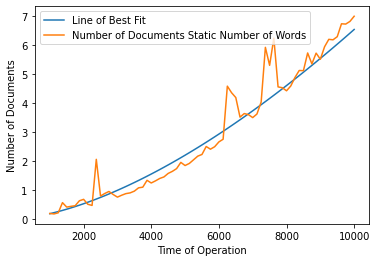

In [44]:
words = choose_n_words(list_of_words_1M, 1, True)

#Plot Jaccard similarity for a varying number of documents with constant document lengths
number_of_docs_range = power_list(10, 3, 4, 80)
doc_length = 1
unique_words = True
similarity_function = "jaccard_similarity"

plot_label = "Number of Documents Static Number of Words"

plot_number_of_docs_vs_time_constant_doc_length(    words,\
                                                    number_of_docs_range,\
                                                    doc_length,\
                                                    unique_words,\
                                                    similarity_function,\
                                                    plot_label)

plt.show()

The above plot shows for a constant document size of 1 that as the number of documents to be compared grows that the runtime approaches $\mathcal{O}(n^2)$. In fact the line of best fit here is $x^{1.58}$ however if we were to take a larger number of documents I believe it would get much closer to $x^{1.58}$. This is unfeasible on my machine.

For d documents the number of combinations when comparing all documents is $d(d-1)$. Therefore, since in the implementation of the comparison algorithm we create 2 list of bags according to the combinations this means, if each bag has 1 word, that for $10^5$ documents we would have 2 lists of lengths $\frac{10^5(10^5-1)}{2} = 4.99995\times10^9$. If each word is 8 characters and therefore 8-bytes then these lists will occupy $\approx40$ Gb of memory which will cause an out of memory error on most personal computers. For a machine with 8Gb of RAM this limits the number of documents able to be compared to

$$
\begin{equation*}
\begin{align*}
8\times10^9 &= 8\times2\times\frac{x(x-1)}{2}\\
x &\approx 3\times10^4
\end{align*}
\end{equation*}
$$

$3\times10^4$ documents.

The lines of best fit are:
* Unique words $\approx ax^1$
* Non-Unique words $\approx ax^1$ 

### Does Similarity Measure Matter For Large Number Non-Unique Words Constant Documents 

[1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000, 105000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000, 850000, 900000, 950000, 1000000]
Line of best fit constants:  LinregressResult(slope=0.9514503143887867, intercept=-10.965298723683869, rvalue=0.9982307217055487, pvalue=4.098979874850507e-69, stderr=0.00764178347770662, intercept_stderr=0.08351797661798897)
Line of best fit constants:  LinregressResult(slope=0.9843899593364926, intercept=-11.373048139435, rvalue=0.999126297775528, pvalue=1.5515010144942606e-77, stderr=0.005552227812536064, intercept_stderr=0.060680969825685195)
Line of best fit constants:  LinregressResult(slope=0.9758386847510647, intercept=-11.26796571022948, rvalue=0.9986341674306639, pvalue=3.34159428

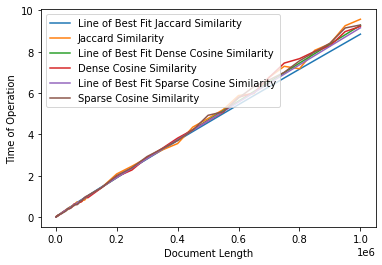

In [46]:
import scipy.stats as stats

words = choose_n_words(list_of_words_1M, 1, True)
unique_words = False

#Plot Jaccard similarity for a constant number of documents with varying document lengths
doc_length_range = power_list(10, 3, 6, 20)
number_of_docs = 2
similarity_function = "jaccard_similarity"
plot_label = "Jaccard Similarity"
best_fit_plot_label = "Line of Best Fit Jaccard Similarity"

plot_doc_length_vs_time_constant_number_of_docs(    words,\
                                                    doc_length_range,\
                                                    number_of_docs,\
                                                    unique_words,\
                                                    similarity_function,\
                                                    plot_label=plot_label,\
                                                    best_fit_plot_label=best_fit_plot_label)

#Plot dense cosine similarity for a constant number of documents with varying document lengths
similarity_function = "dense_cosine_similarity"
plot_label = "Dense Cosine Similarity"
best_fit_plot_label = "Line of Best Fit Dense Cosine Similarity"

plot_doc_length_vs_time_constant_number_of_docs(    words,\
                                                    doc_length_range,\
                                                    number_of_docs,\
                                                    unique_words,\
                                                    similarity_function,\
                                                    plot_label=plot_label,\
                                                    best_fit_plot_label=best_fit_plot_label)

#Plot sparse cosine similarity for a constant number of documents with varying document lengths
similarity_function = "sparse_cosine_similarity"
plot_label = "Sparse Cosine Similarity"
best_fit_plot_label = "Line of Best Fit Sparse Cosine Similarity"

plot_doc_length_vs_time_constant_number_of_docs(    words,\
                                                    doc_length_range,\
                                                    number_of_docs,\
                                                    unique_words,\
                                                    similarity_function,\
                                                    plot_label=plot_label,\
                                                    best_fit_plot_label=best_fit_plot_label)

Here we can see that the type of similarity measure used does not affect the time complexity for comparing a constant number of documents, it grows linearly with increasing document length. However, as before when comparing runtimes of the individual similarity algorithms there is a difference in the gradient for each. This is the same here with Jaccard beign the fastest, followed by sparse cosine and finally dense cosine. This is much for the same reason as before.

The lines of best fit are:
* Unique words $\approx ax^1$
* Non-Unique words $\approx ax^1$ 

### Does Similarity Measure Matter For Large Number Documents With Constant Lengths

Line of Best Fit constants:  LinregressResult(slope=1.7352729608877877, intercept=-13.746629919535838, rvalue=0.9944604909819382, pvalue=4.4721058066467135e-18, stderr=0.04448403368533499, intercept_stderr=0.3766542381424877)
Line of Best Fit constants:  LinregressResult(slope=1.7021186101322772, intercept=-13.445699540496735, rvalue=0.9914868025642738, pvalue=1.7078448043369728e-16, stderr=0.0542142545728884, intercept_stderr=0.45904175185772356)
Line of Best Fit constants:  LinregressResult(slope=1.6875283718679617, intercept=-13.535680955417407, rvalue=0.9936052529171332, pvalue=1.5109691215498044e-17, stderr=0.04650975101620899, intercept_stderr=0.3938063476690101)


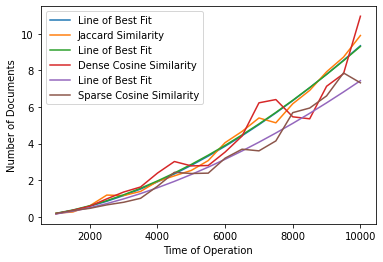

In [48]:
words = choose_n_words(list_of_words_1M, 1, True)
unique_words = True

number_of_docs_range = power_list(10, 3, 4, 20)
doc_length = 1
similarity_function = "jaccard_similarity"
plot_label = "Jaccard Similarity"
best_fit_plot_label = "Line of Best Fit Jaccard Similarity"

#Plot jaccard similarity for a varying number of documents with  constant document lengths
plot_number_of_docs_vs_time_constant_doc_length(    words,\
                                                    number_of_docs_range,\
                                                    doc_length,\
                                                    unique_words,\
                                                    similarity_function,\
                                                    plot_label)

#Plot dense cosine similarity for a varying number of documents with  constant document lengths
similarity_function = "dense_cosine_similarity"
plot_label = "Dense Cosine Similarity"
best_fit_plot_label = "Line of Best Fit Dense Cosine Similarity"

plot_number_of_docs_vs_time_constant_doc_length(    words,\
                                                    number_of_docs_range,\
                                                    doc_length,\
                                                    unique_words,\
                                                    similarity_function,\
                                                    plot_label)

#Plot sparse cosine similarity for a varying number of documents with  constant document lengths
similarity_function = "sparse_cosine_similarity"
plot_label = "Sparse Cosine Similarity"
best_fit_plot_label = "Line of Best Fit Sparse Cosine Similarity"

plot_number_of_docs_vs_time_constant_doc_length(    words,\
                                                    number_of_docs_range,\
                                                    doc_length,\
                                                    unique_words,\
                                                    similarity_function,\
                                                    plot_label)

plt.show()

Here we can see that the type of similarity measure used does not affect the time complexity for comparing increasing numbers of constant size documents. For every function the runtime approaches $\mathcal{O}(n^2)$. There is variation in the graidents for the different measures but this is the same as before. Since the runtime is $\mathcal{O}(n^2)$ we can estimate that to compare 200K documents would take $\approx 40\times10^9$ longer than comparing two documents.

The lines of best fit are:
* Unique words $\approx ax^1$
* Non-Unique words $\approx ax^1$ 

<center> <h1>Section V - Computing Similarities For Multiple Documents In Parallel</h1> </center>


In this section we will compute all-pairs similarities for a collection of documents using parallel computing. We will test this against the method the computes sequentially to see if parallelisation increases the efficiency. We will also investigate the optimal number of parallel processes to use.

In [43]:
from pathos.multiprocessing import ProcessingPool as Pool

#Function which computes all-pairs similarities for a collection of documents
def compute_similarities_parallel(documents: list, similarity_function: str, map_processes=1):
    bags=[]
    for doc in documents:
        bag = Bag(word_tokenize(doc))
        bags.append(bag)
    
    #Assign correct similarity function depending on input
    if similarity_function == "jaccard_similarity":
        func = jaccard_similarity
    elif similarity_function == "dense_cosine_similarity":
        func = dense_cosine_similarity
    elif similarity_function == "sparse_cosine_similarity":
        func = sparse_cosine_similarity
    else:
        raise ValueError("Invalid similarity function")

    #Map pool to apply mapping functions
    map_pool = Pool(processes=map_processes)

    #Mapping function for two bags   
    similarity_mapper = lambda i, j, bag_1, bag_2: (i, j, func(bag_1, bag_2))

    combinations = itertools.combinations(range(len(bags)), 2)
    indices_1 = [x[0] for x in combinations]
    indices_2 = [x[1] for x in combinations]
    bags_1 = [bags[x]  for x in indices_1]
    bags_2 = [bags[x]  for x in indices_2]

    #Store results of each mapping function
    similarity_map=map_pool.map(similarity_mapper, indices_1, indices_2, bags_1, bags_2)

    #Close and clear map pool to prevent errors using in the future
    map_pool.close()
    map_pool.clear()

    #Collect map results into list for reducing
    similarities = list(similarity_map)

    return similarities

### Compute Similarities Sequential vs Parallel

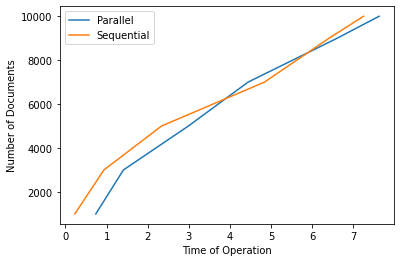

In [31]:
words = list_of_words_1M
documents = []

number_of_documents_sequential = []
times_sequential = []

number_of_documents_parallel = []
times_parallel = []

number_of_docs_range = power_list(10, 3, 4, 5)

#For a varying number of documents with fixed size time how long it takes to compute
#Jaccard similarity for all pairs of documents for the sequential and parallel versions
for i in number_of_docs_range:
    
    documents = []
    for j in range(i):
        documents.append(' '.join(choose_n_words(words, 1, False)))

    results_parallel = timeit(compute_similarities_parallel, documents, "jaccard_similarity", map_processes=4, repeats=4)
    results_sequential = timeit(compute_similarities, documents, "jaccard_similarity", repeats=4)

    times_parallel.append(results_parallel[1])
    number_of_documents_parallel.append(i)

    times_sequential.append(results_sequential[1])
    number_of_documents_sequential.append(i)

plt.plot(times_parallel, number_of_documents_parallel, label="Parallel")
plt.plot(times_sequential, number_of_documents_sequential, label="Sequential")

plt.xlabel("Time of Operation")
plt.ylabel("Number of Documents")
plt.legend()
plt.show()

This plot shows that the parallel implementation of the pair similarity calculation algorithm performs worse than the sequential version. This is most likely due to the overhead of managing mulitple processes and having to serialise and deserialise the data for different threads.

### Compute Similarities Parallel Processor Comparison Constant Document Size

[10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000, 46000, 47000, 48000, 49000, 50000, 51000, 52000, 53000, 54000, 55000, 56000, 57000, 58000, 59000, 60000, 61000, 62000, 63000, 64000, 65000, 66000, 67000, 68000, 69000, 70000, 71000, 72000, 73000, 74000, 75000, 76000, 77000, 78000, 79000, 80000, 81000, 82000, 83000, 84000, 85000, 86000, 87000, 88000, 89000, 90000, 91000, 92000, 93000, 94000, 95000, 96000, 97000, 98000, 99000, 100000]
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]


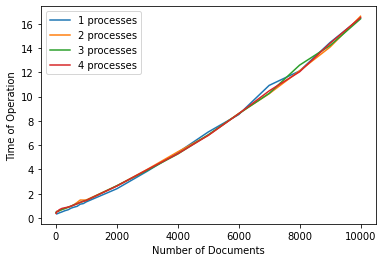

In [22]:
words = list_of_words_1M

number_of_words_range = power_list(10, 4, 5, 100)
print(number_of_words_range)

number_of_docs_range = power_list(10, 1, 4, 10)
print(number_of_docs_range)

processor_range = range(1, 5)

#For a varying number of documents with fixed size time how long it takes to compute
#Jaccard similarity for all pairs of documents for parallel version algorithm using
#different numbers of processes
for x in processor_range:
    number_of_docs = []
    times = []
    for i in number_of_docs_range:
        docs = []
        for j in range(i):
            docs.append(' '.join(choose_n_words(words, 200)))

        results = timeit(compute_similarities_parallel, docs, "jaccard_similarity", map_processes=x, repeats=1)

        times.append(results[1])
        number_of_docs.append(i)

    plt.plot(number_of_docs, times, label=str(x) + " processes")

plt.ylabel("Time of Operation")
plt.xlabel("Number of Documents")
plt.legend()
plt.show()

This plot seems to show that for an increasing number of documents with constant sizes the parallel comparison algorithm does not gain any benefit from extra processes. That is surprising but maybe due to the small document sizes not much time is actually spent computing the similarity between any two documents. This could mean that the overhead of managing the different processes does not produce a gain in speed.

### Compute Similarities Parallel Processor Comparison Constant Number of Documents

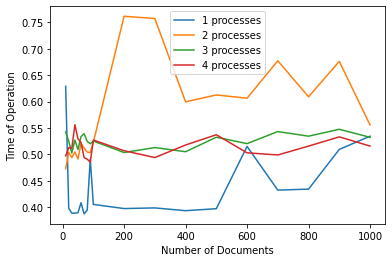

In [35]:
map_pool = Pool(processes=1)
map_pool.close()
map_pool.clear()

words = list_of_words_1M

number_of_words_range = power_list(10, 1, 3, 10)

number_of_docs_to_compare = 4

processor_range = range(1, 5)

#For a varying constant number of documents with varying size time how long it takes to compute
#Jaccard similarity for all pairs of documents for parallel version algorithm using
#different numbers of processes
for x in processor_range:
    number_of_docs = []
    times = []
    for i in number_of_words_range:
        docs = []
        for j in range(number_of_docs_to_compare):
            docs.append(' '.join(choose_n_words(words, i, True)))

        results = timeit(compute_similarities_parallel, docs, "jaccard_similarity", map_processes=x, repeats=1)

        times.append(results[1])
        number_of_docs.append(i)

    plt.plot(number_of_docs, times, label=str(x) + " processes")


plt.ylabel("Time of Operation")
plt.xlabel("Number of Documents")
plt.legend()
plt.show()

This plot seems to show that for a constant number of documents with increasing sizes the parallel comparison algorithm does not gain any benefit from extra processes. In fact it seems to be the case that a single process is better. 

<center> <h1>Conclusion</h1> </center>



<center> <h1>Unit Tests</h1> </center>

In these unit tests we check the functionality of the Bag class, the different similarity functions, the document pair similarity function, and the parallel document pair similarity function.

In [38]:
import unittest

class TestBagFunctionality(unittest.TestCase):
    #Unit tests
    def test_add_bag(self):
        bag = Bag()
        bag.add(1)
        self.assertTrue(bag.values() == [1])
        bag.add(2)
        self.assertTrue(bag.values() == [1,2])
        bag.add(3)
        self.assertTrue(bag.values() == [1,2,3])

    def test_len_bag(self):
        bag = Bag()
        bag.add(1)
        self.assertTrue(len(bag) == 1)
        bag.add(2)
        self.assertTrue(len(bag) == 2)
        bag.add(3)
        self.assertTrue(len(bag) == 3)

    def test_remove_bag(self):
        bag = Bag()
        bag.add(1)
        bag.add(2)
        bag.add(3)
        bag.remove(2)
        self.assertTrue(bag.values() == [1,3])
        bag.remove(1)
        self.assertTrue(bag.values() == [3])
        bag.remove(3)
        self.assertTrue(bag.values() == [])

    def test_count_bag(self):
        bag = Bag()
        bag.add(1)
        bag.add(2)
        bag.add(3)
        self.assertTrue(bag.count(1) == 1)
        self.assertTrue(bag.count(2) == 1)
        self.assertTrue(bag.count(3) == 1)
        bag.remove(2)
        self.assertTrue(bag.count(2) == 0)

    def test_counts_bag(self):
        bag = Bag()
        bag.add(1)
        bag.add(2)
        bag.add(3)
        bag.add(2)
        bag.add(3)
        bag.add(3)
        self.assertTrue(bag.counts() == {1:1, 2:2, 3:3})

    def test_iterator_bag(self):
        bag = Bag()
        bag.add(1)
        bag.add(2)
        bag.add(3)
        for i,j in zip(bag, [1,2,3]):
            self.assertTrue(i == j)

    def test_str_bag(self):
        bag = Bag()
        bag.add(1)
        bag.add(2)
        bag.add(3)
        self.assertTrue(str(bag) == "[1, 2, 3]")

    def test_repr_bag(self):
        bag = Bag()
        bag.add(1)
        bag.add(2)
        bag.add(3)
        self.assertTrue(repr(bag) == "[1, 2, 3]")

    def test_len_bag(self):
        bag = Bag()
        bag.add(1)
        bag.add(2)
        bag.add(3)
        self.assertTrue(len(bag) == 3)

    def test_getitem_bag(self):    
        bag = Bag()
        bag.add(1)
        bag.add(2)
        bag.add(3)
        self.assertTrue(bag[0] == 1)
        self.assertTrue(bag[1] == 2)
        self.assertTrue(bag[2] == 3)

    def test_values_bag(self):
        bag = Bag()
        bag.add(1)
        bag.add(2)
        bag.add(3)
        self.assertTrue(bag.values() == [1,2,3])

    def test_size_bag(self):
        bag = Bag()
        bag.add(1)
        bag.add(2)
        bag.add(3)
        self.assertTrue(bag.size() == 3)

In [41]:
import itertools

docs=[]

docs.append("The module teaches the computer science aspects of data science. A particular focus is on how data are represented and manipulated to achieve good performance on large data sets (> 10 GBytes) where standard techniques may no longer apply. In lectures, students will learn about data structures, algorithms, and systems, including distributed computing, databases (relational and non-relational), parallel computing, and cloud computing. In laboratory sessions, students will develop their Python programming skills; work with a variety of data sets including large data sets from real world applications; and investigate the impact on run-time of their algorithmic choices.")
docs.append("This module introduces you to the mathematical and statistical techniques used to analyse data. The module is fairly rigorous, and is aimed at students who have, or anticipate having, research data to analyse in a thorough and unbiased way.  Topics include: probability distributions; error propagation; maximum likelihood method and linear least squares fitting; chi-squared testing; subjective probability and Bayes' theorem; monte Carlo techniques; and non-linear least squares fitting.")
docs.append("In this module, you use literature to study the background to a problem in Data Science in your respective stream.  You choose your individual supervisor and devise a strategy by which this problem can be studied - giving details of techniques and resources that you will use to address the problem.  This research proposal forms the basis of the Data Science Dissertation that you will write in summer term.")
docs.append("For this module, you carry out independent study and research under the guide of a supervisor on a designated topic. You then complete a report on the subject over the summer.")
docs.append("In this module, you explore advanced techniques in machine learning. You use a systematic treatment, based on the following three key ingredients: tasks, models, features.  As part of the module, you are introduced to both regression and classification, and your studies emphasise concepts such as model performance, learnability and computational complexity.  You learn techniques including: probabilistic and non-probabilistic classification and regression methods, reinforcement learning approaches including the non-linear variants using kernel methods.  You are also introduced to techniques for pre-processing the data (including PCA). You will then need to be able to implement, develop and deploy these techniques to real-world problems.  In order to take this module, you need to have already taken the 'Mathematics & Computational Methods for Complex Systems' module (817G5), or have taken an equivalent mathematical module or have equivalent prior experience.")
docs.append("Your studies in this module include a series of seminars covering several topics - including national laws on data and ethical implications.  In addition, there are seminars by Data-Science-oriented companies.  You are expected to write a final dissertation of 3000 words, on a topic of your choice falling within the scope of the module.")
docs.append("This module will provide students with the practical tools and techniques required to build, analyse and interpret 'big data' datasets. It will cover all aspects of the Data Science process including collection, munging or wrangling, cleaning, exploratory data analysis, visualization, statistical inference and model building and implications for applications in the real world. During the module, they will be taught how to scrape data from the Internet, develop and test hypotheses, use principal component analysis (PCA) to reduce dimensionality, prepare actionable plans and present their findings. In the laboratory, students will develop their Python programming skills and be introduced to a number of fundamental standard Python libraries/toolkits for Data Scientists including NumPy, SciPy, PANDAS and SCIKIT-Learn. In these sessions and their coursework, students will work with real-world datasets and apply the techniques covered in lectures to that data.")

jaccard_similarity_ground_truth_values = [ (0, 1, 0.13218390804597702), \
                                (0, 2, 0.09941520467836257), \
                                (0, 3, 0.07971014492753623), \
                                (0, 4, 0.1652542372881356), \
                                (0, 5, 0.12987012987012986), \
                                (0, 6, 0.2672811059907834), \
                                (1, 2, 0.12318840579710146), \
                                (1, 3, 0.08411214953271028), \
                                (1, 4, 0.14150943396226415), \
                                (1, 5, 0.11023622047244094), \
                                (1, 6, 0.14150943396226415), \
                                (2, 3, 0.20224719101123595), \
                                (2, 4, 0.14215686274509803), \
                                (2, 5, 0.1891891891891892), \
                                (2, 6, 0.1477832512315271), \
                                (3, 4, 0.08379888268156424), \
                                (3, 5, 0.2077922077922078), \
                                (3, 6, 0.05434782608695652), \
                                (4, 5, 0.12307692307692308), \
                                (4, 6, 0.2260536398467433), \
                                (5, 6, 0.095)]
                    
cosine_similarity_ground_truth_values = [ (0, 1, 0.47116952883259133), \
                                (0, 2, 0.29370130064810657), \
                                (0, 3, 0.3386670053338413), \
                                (0, 4, 0.5633814220979646), \
                                (0, 5, 0.4483931360446881), \
                                (0, 6, 0.7172112418628068), \
                                (1, 2, 0.328998024879378), \
                                (1, 3, 0.26499947000158997), \
                                (1, 4, 0.5071685033587473), \
                                (1, 5, 0.2845312162312832), \
                                (1, 6, 0.5170799069507365), \
                                (2, 3, 0.48686449556014766), \
                                (2, 4, 0.48980381711988424), \
                                (2, 5, 0.45917121711588194), \
                                (2, 6, 0.4728636701656281), \
                                (3, 4, 0.42459524785140024), \
                                (3, 5, 0.5368524250814087), \
                                (3, 6, 0.3622078674589313), \
                                (4, 5, 0.47814196858924696), \
                                (4, 6, 0.7089821393308153), \
                                (5, 6, 0.41535119570251716)]

class TestJaccardFunctionality(unittest.TestCase):
    def test_jaccard_bags(self):
        ground_truth_values = jaccard_similarity_ground_truth_values
        
        bags=[]
        for doc in docs:
            bag = Bag(word_tokenize(doc))
            bags.append(bag)

        #For each count in counts compute the jaccard similarity between counts
        jaccard_similarities = []
        for i,j in list(itertools.combinations(range(len(bags)), 2)):
            jaccard_similarities.append((i, j, jaccard_similarity(bags[i], bags[j])))

        # Print the jaccard similarities
        for x, y in zip(jaccard_similarities, ground_truth_values):
            self.assertTrue(x == y)

class TestCosineFunctionality(unittest.TestCase):
    def test_dense_cosine_bags(self):
        ground_truth_values = cosine_similarity_ground_truth_values
        
        bags=[]
        for doc in docs:
            bag = Bag(word_tokenize(doc))
            bags.append(bag)

        #For each count in counts compute the jaccard similarity between counts
        cosine_similarities = []
        for i,j in list(itertools.combinations(range(len(bags)), 2)):
            cosine_similarities.append((i, j, dense_cosine_similarity(bags[i], bags[j])))

        # Check the jaccard similarities
        for x, y in zip(cosine_similarities, ground_truth_values):
            self.assertTrue(x == y)
    
    def test_sparse_cosine_bags(self):
        ground_truth_values = cosine_similarity_ground_truth_values
        
        bags=[]
        for doc in docs:
            bag = Bag(word_tokenize(doc))
            bags.append(bag)

        #For each count in counts compute the jaccard similarity between counts
        cosine_similarities = []
        for i,j in list(itertools.combinations(range(len(bags)), 2)):
            cosine_similarities.append((i, j, sparse_cosine_similarity(bags[i], bags[j])))

        # Check the jaccard similarities
        for x, y in zip(cosine_similarities, ground_truth_values):
            self.assertTrue(x == y)
    
#Test parallel compute similarity function for all inputs
class TestComputeSimilarityFunctionality(unittest.TestCase):
    def test_jaccard(self):
        ground_truth_values = jaccard_similarity_ground_truth_values
        
        similarities = compute_similarities(docs, "jaccard_similarity")
        
        # Check the jaccard similarities
        for x, y in zip(similarities, ground_truth_values):
            self.assertTrue(x == y)
    
    def test_dense_cosine(self):
        ground_truth_values = cosine_similarity_ground_truth_values
        
        similarities = compute_similarities(docs, "dense_cosine_similarity")
        
        # Check the dense cosine similarities
        for x, y in zip(similarities, ground_truth_values):
            self.assertTrue(x == y)
    
    def test_sparse_cosine(self):
        ground_truth_values = cosine_similarity_ground_truth_values
        
        similarities = compute_similarities(docs, "sparse_cosine_similarity")
        
        # Check the sparse cosine similarities
        for x, y in zip(similarities, ground_truth_values):
            self.assertTrue(x == y)

class TestComputeParallelJaccardSimilarityFunctionality(unittest.TestCase):
    def test_jaccard_parallel(self):
        ground_truth_values = compute_similarities(docs, "jaccard_similarity")
        
        similarities = compute_similarities_parallel(docs, "jaccard_similarity")

        # Check the jaccard similarities
        for x, y in zip(similarities, ground_truth_values):
            self.assertTrue(x == y)

class TestComputeParallelCosineSimilarityFunctionality(unittest.TestCase):
    def test_cosine_parallel(self):
        ground_truth_values = compute_similarities(docs, "dense_cosine_similarity")
        
        similarities = compute_similarities_parallel(docs, "dense_cosine_similarity")

        # Check the cosine similarities
        for x, y in zip(similarities, ground_truth_values):
            self.assertTrue(x == y)

In [42]:
if __name__ == "__main__":
    unittest.main(argv=[''], verbosity=2, exit=False)

test_add_bag (__main__.TestBagFunctionality) ... ok
test_count_bag (__main__.TestBagFunctionality) ... ok
test_counts_bag (__main__.TestBagFunctionality) ... ok
test_getitem_bag (__main__.TestBagFunctionality) ... ok
test_iterator_bag (__main__.TestBagFunctionality) ... ok
test_len_bag (__main__.TestBagFunctionality) ... ok
test_remove_bag (__main__.TestBagFunctionality) ... ok
test_repr_bag (__main__.TestBagFunctionality) ... ok
test_size_bag (__main__.TestBagFunctionality) ... ok
test_str_bag (__main__.TestBagFunctionality) ... ok
test_values_bag (__main__.TestBagFunctionality) ... ok
test_cosine_parallel (__main__.TestComputeParallelCosineSimilarityFunctionality) ... ok
test_jaccard_parallel (__main__.TestComputeParallelJaccardSimilarityFunctionality) ... ok
test_dense_cosine (__main__.TestComputeSimilarityFunctionality) ... ok
test_jaccard (__main__.TestComputeSimilarityFunctionality) ... ok
test_sparse_cosine (__main__.TestComputeSimilarityFunctionality) ... ok
test_dense_cosine_b